In [1]:
import numpy as np
import gym
import gym_sokoban
import matplotlib.pyplot as plt
from sokoban_env import SokobanEnv
from custom_sokoban_env import my_sokoban_env
import time
import copy
import random 
import itertools

# Check System Requirements

In [2]:
# pip install gym==0.21.0

In [3]:
import gym

print(gym.__version__)

0.21.0


In [4]:
import sys

print(sys.version)

3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]


# Define the environment and number of boxes

In [5]:
# # Create the Sokoban environment from sokoban versions.
# env_name = 'Sokoban-v2'
# game_env = gym.make(env_name)

In [6]:
# Create the Sokoban environment custom
game_env = my_sokoban_env(dim_room=(10, 10), num_boxes=3)

In [7]:
# Function to convert state to a tuple
def state_to_tuple(state):
    return tuple(state.reshape(-1))

# Save the original state of the environment
# initial_state = game_env.second_reset()
# initial_state_tuple = state_to_tuple(initial_state)
# game_env.render(mode='human')

In [8]:
# Action lookup
ACTION_LOOKUP = game_env.unwrapped.get_action_lookup()
# Convert state to tuple representation (for tabular SARSA)
def state_to_tuple(state):
    return tuple(state.ravel())

# Save One Initial State for Consistancy

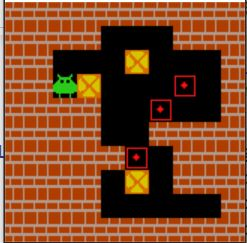

In [9]:
# We need to save the exact one we see below so comment this when selected the desired env topology
# initial_agent_position = game_env.player_position
# initial_box_mapping = game_env.box_mapping
# initial_room_fixed = game_env.room_fixed
# initial_room_state = game_env.room_state

In [10]:
initial_room_state = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                               [0, 0, 1, 1, 1, 4, 1, 1, 1, 0],
                               [0, 0, 5, 4, 1, 1, 1, 2, 1, 0],
                               [0, 0, 0, 0, 1, 1, 2, 1, 1, 0],
                               [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 2, 1, 0, 0, 0],
                               [0, 0, 0, 0, 1, 4, 1, 0, 0, 0],
                               [0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
initial_room_fixed = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                               [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
                               [0, 0, 1, 1, 1, 1, 1, 2, 1, 0],
                               [0, 0, 0, 0, 1, 1, 2, 1, 1, 0],
                               [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 2, 1, 0, 0, 0],
                               [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                               [0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
initial_box_mapping = np.array({(3, 7): (7, 5), (4, 6): (3, 3), (6, 5): (2, 5)})

In [13]:
initial_agent_position = np.array([3,2])

# Implement the RL Algorithms

## SARSA Algorithm

In [14]:
num_episodes = 1000
learning_rate = 0.1
discount_factor = 0.99
exploration_prob = 0.05

sarsa_q_table = {} 

# Training the agent
game_env = my_sokoban_env(initial_agent_position=initial_agent_position,
    initial_box_mapping=initial_box_mapping,
    initial_room_fixed=initial_room_fixed,
    initial_room_state=initial_room_state)
# SARSA algorithm
for episode in range(num_episodes):

    #print('starting episode', episode+1)
    state = game_env.second_reset() 
    # Updated the initial variables with the current state returned by second_reset()
    state_tuple = state_to_tuple(state)
    done = False
    sarsa_total_reward = 0

    # Initialize Q-values for the current state if not present
    if state_tuple not in sarsa_q_table:
        sarsa_q_table[state_tuple] = np.zeros(game_env.action_space.n)

    # Choose the initial action based on epsilon-greedy policy
    if np.random.rand() < exploration_prob :
        action = game_env.action_space.sample()
    else:
        action = np.argmax(sarsa_q_table[state_tuple])

    while not done:
        game_env.render(mode='human')

        # Take the chosen action
        next_state, reward, done, _ = game_env.step(action)
        next_state_tuple = state_to_tuple(next_state)

        # Initialize Q-values for the next state if not present
        if next_state_tuple not in sarsa_q_table:
            sarsa_q_table[next_state_tuple] = np.zeros(game_env.action_space.n)

        # Choose the next action based on epsilon-greedy policy
        if np.random.rand() < exploration_prob :
            next_action = game_env.action_space.sample()
        else:
            next_action = np.argmax(sarsa_q_table[next_state_tuple])

        # SARSA Q-value update
        q_value = sarsa_q_table[state_tuple][action]
        next_q_value = sarsa_q_table[next_state_tuple][next_action]
        sarsa_q_table[state_tuple][action] = q_value + learning_rate * (reward + discount_factor * next_q_value - q_value)

        state = next_state.copy()  # Copy the next_state into the state variable
        state_tuple = next_state_tuple
        action = next_action
        sarsa_total_reward += reward

        if done:
            print("Episode: {}, Total Reward: {}".format(episode + 1, sarsa_total_reward))
            break


Episode: 1, Total Reward: -10.999999999999977
Episode: 2, Total Reward: -10.999999999999977
Episode: 3, Total Reward: -9.999999999999977
Episode: 4, Total Reward: -10.999999999999977
Episode: 5, Total Reward: -10.999999999999977
Episode: 6, Total Reward: -9.999999999999977
Episode: 7, Total Reward: -9.999999999999977
Episode: 8, Total Reward: -9.999999999999982
Episode: 9, Total Reward: -10.999999999999977
Episode: 10, Total Reward: -9.999999999999977
Episode: 11, Total Reward: -9.99999999999998
Episode: 12, Total Reward: -10.999999999999977
Episode: 13, Total Reward: -10.999999999999977
Episode: 14, Total Reward: -10.999999999999977
Episode: 15, Total Reward: -10.999999999999977
Episode: 16, Total Reward: -10.999999999999979
Episode: 17, Total Reward: -9.999999999999977
Episode: 18, Total Reward: -10.999999999999977
Episode: 19, Total Reward: -10.999999999999977
Episode: 20, Total Reward: -9.99999999999998
Episode: 21, Total Reward: -10.999999999999977
Episode: 22, Total Reward: -10.9

Episode: 177, Total Reward: -9.999999999999982
Episode: 178, Total Reward: -9.999999999999982
Episode: 179, Total Reward: -9.999999999999986
Episode: 180, Total Reward: -10.999999999999982
Episode: 181, Total Reward: -9.999999999999982
Episode: 182, Total Reward: -9.999999999999982
Episode: 183, Total Reward: -8.999999999999986
Episode: 184, Total Reward: -9.999999999999982
Episode: 185, Total Reward: -8.999999999999982
Episode: 186, Total Reward: -9.999999999999982
Episode: 187, Total Reward: -10.999999999999982
Episode: 188, Total Reward: -9.999999999999982
Episode: 189, Total Reward: -9.999999999999982
Episode: 190, Total Reward: -9.999999999999982
Episode: 191, Total Reward: -9.999999999999982
Episode: 192, Total Reward: -9.999999999999986
Episode: 193, Total Reward: -9.999999999999979
Episode: 194, Total Reward: -9.999999999999982
Episode: 195, Total Reward: -9.999999999999982
Episode: 196, Total Reward: -9.999999999999982
Episode: 197, Total Reward: -8.999999999999986
Episode: 19

Episode: 351, Total Reward: -8.999999999999986
Episode: 352, Total Reward: -9.999999999999982
Episode: 353, Total Reward: -8.999999999999986
Episode: 354, Total Reward: -8.999999999999986
Episode: 355, Total Reward: -8.999999999999986
Episode: 356, Total Reward: -9.999999999999982
Episode: 357, Total Reward: -8.999999999999986
Episode: 358, Total Reward: -9.999999999999982
Episode: 359, Total Reward: -9.99999999999998
Episode: 360, Total Reward: -10.999999999999982
Episode: 361, Total Reward: -8.999999999999986
Episode: 362, Total Reward: -9.999999999999982
Episode: 363, Total Reward: -8.999999999999986
Episode: 364, Total Reward: -8.999999999999986
Episode: 365, Total Reward: -9.999999999999982
Episode: 366, Total Reward: -9.999999999999982
Episode: 367, Total Reward: -8.999999999999986
Episode: 368, Total Reward: -9.99999999999998
Episode: 369, Total Reward: -8.999999999999986
Episode: 370, Total Reward: -9.999999999999982
Episode: 371, Total Reward: -8.999999999999986
Episode: 372, 

Episode: 526, Total Reward: -8.999999999999986
Episode: 527, Total Reward: -8.999999999999986
Episode: 528, Total Reward: -8.999999999999986
Episode: 529, Total Reward: -9.999999999999984
Episode: 530, Total Reward: -9.999999999999988
Episode: 531, Total Reward: -9.99999999999998
Episode: 532, Total Reward: -8.999999999999986
Episode: 533, Total Reward: -8.999999999999986
Episode: 534, Total Reward: -8.999999999999986
Episode: 535, Total Reward: -8.999999999999986
Episode: 536, Total Reward: -10.999999999999977
Episode: 537, Total Reward: -9.999999999999986
Episode: 538, Total Reward: -8.999999999999986
Episode: 539, Total Reward: -8.999999999999986
Episode: 540, Total Reward: -8.999999999999986
Episode: 541, Total Reward: -9.999999999999986
Episode: 542, Total Reward: -8.999999999999986
Episode: 543, Total Reward: -9.999999999999982
Episode: 544, Total Reward: -9.999999999999982
Episode: 545, Total Reward: -8.999999999999986
Episode: 546, Total Reward: -10.999999999999977
Episode: 547

Episode: 709, Total Reward: 11.3
Episode: 710, Total Reward: 11.9
Episode: 711, Total Reward: 11.799999999999999
Episode: 712, Total Reward: 11.9
Episode: 713, Total Reward: 11.7
Episode: 714, Total Reward: 11.9
Episode: 715, Total Reward: -8.999999999999986
Episode: 716, Total Reward: 11.9
Episode: 717, Total Reward: 6.3999999999999995
Episode: 718, Total Reward: 11.9
Episode: 719, Total Reward: 11.7
Episode: 720, Total Reward: 11.7
Episode: 721, Total Reward: 11.9
Episode: 722, Total Reward: -9.99999999999998
Episode: 723, Total Reward: 10.299999999999999
Episode: 724, Total Reward: 11.9
Episode: 725, Total Reward: 11.7
Episode: 726, Total Reward: 11.5
Episode: 727, Total Reward: 11.9
Episode: 728, Total Reward: 11.799999999999999
Episode: 729, Total Reward: 11.799999999999999
Episode: 730, Total Reward: 11.9
Episode: 731, Total Reward: 11.9
Episode: 732, Total Reward: -10.999999999999982
Episode: 733, Total Reward: 11.9
Episode: 734, Total Reward: 11.799999999999999
Episode: 735, To

Episode: 935, Total Reward: 11.9
Episode: 936, Total Reward: 11.799999999999999
Episode: 937, Total Reward: 11.9
Episode: 938, Total Reward: 11.9
Episode: 939, Total Reward: 11.799999999999999
Episode: 940, Total Reward: 11.6
Episode: 941, Total Reward: 11.9
Episode: 942, Total Reward: 11.9
Episode: 943, Total Reward: 11.9
Episode: 944, Total Reward: 11.799999999999999
Episode: 945, Total Reward: 11.799999999999999
Episode: 946, Total Reward: 11.9
Episode: 947, Total Reward: 11.5
Episode: 948, Total Reward: 11.1
Episode: 949, Total Reward: 11.9
Episode: 950, Total Reward: 11.9
Episode: 951, Total Reward: -9.999999999999982
Episode: 952, Total Reward: 11.7
Episode: 953, Total Reward: -9.999999999999982
Episode: 954, Total Reward: 11.4
Episode: 955, Total Reward: 11.9
Episode: 956, Total Reward: 11.4
Episode: 957, Total Reward: 11.7
Episode: 958, Total Reward: 11.799999999999999
Episode: 959, Total Reward: 11.6
Episode: 960, Total Reward: 11.9
Episode: 961, Total Reward: 11.4
Episode: 96

In [15]:
# Function to test the agent's performance in one final test episode using the learned Q-table
def test_agent(q_table, game_env):
    state = game_env.second_reset() 
    # Updated the initial variables with the current state returned by second_reset()
    state_tuple = state_to_tuple(state)
    done = False
    total_reward = 0

    while not done:
        # Choose the best action based on the Q-table
        action = np.argmax(q_table[state_tuple])
        game_env.render(mode='human')
        next_state, reward, done, _ = game_env.step(action)
        next_state_tuple = state_to_tuple(next_state)

        state = next_state.copy()
        state_tuple = next_state_tuple
        total_reward += reward

    return total_reward

# Initialize the game environment
game_env = my_sokoban_env(initial_agent_position=initial_agent_position,
                          initial_box_mapping=initial_box_mapping,
                          initial_room_fixed=initial_room_fixed,
                          initial_room_state=initial_room_state)

# Test the agent using the trained Q-table for one final episode
final_reward = test_agent(sarsa_q_table, game_env)

# Print the final reward obtained in the test episode
print("Final Test Episode Reward:", final_reward)


Final Test Episode Reward: 11.9


## Q-Learning Algorithm

In [16]:
# Q-Learning
num_episodes = 1000
learning_rate = 0.1
discount_factor = 0.99
exploration_prob = 0.05

q_table = {} 

# Training the agent
game_env = my_sokoban_env(initial_agent_position=initial_agent_position,
    initial_box_mapping=initial_box_mapping,
    initial_room_fixed=initial_room_fixed,
    initial_room_state=initial_room_state)
# Q-Learning algorithm
for episode in range(num_episodes):

    #print('starting episode', episode+1)   
    state = game_env.second_reset() 
    # Updated the initial variables with the current state returned by second_reset()
    state_tuple = state_to_tuple(state)
    done = False
    total_reward = 0

    # Initialize Q-values for the current state if not present
    if state_tuple not in q_table:
        q_table[state_tuple] = np.zeros(game_env.action_space.n)

    # Choose the initial action based on epsilon-greedy policy
    if np.random.rand() < exploration_prob :
        action = game_env.action_space.sample()
    else:
        action = np.argmax(q_table[state_tuple])

    while not done:
        game_env.render(mode='human')

        # Take the chosen action
        next_state, reward, done, _ = game_env.step(action)
        next_state_tuple = state_to_tuple(next_state)

        # Initialize Q-values for the next state if not present
        if next_state_tuple not in q_table:
            q_table[next_state_tuple] = np.zeros(game_env.action_space.n)

        # Choose the next action based on epsilon-greedy policy
        if np.random.rand() < exploration_prob :
            next_action = game_env.action_space.sample()
        else:
            next_action = np.argmax(q_table[next_state_tuple])

        # SARSA Q-value update
        q_value = q_table[state_tuple][action]
        max_next_q_value = np.max(q_table[next_state_tuple])
        q_table[state_tuple][action] = q_value + learning_rate * (reward + discount_factor * max_next_q_value - q_value)

        state = next_state.copy()  # Copy the next_state into the state variable
        state_tuple = next_state_tuple
        action = next_action
        total_reward += reward

        if done:
            print("Episode: {}, Total Reward: {}".format(episode + 1, total_reward))
            break


Episode: 1, Total Reward: -10.999999999999977
Episode: 2, Total Reward: -10.999999999999977
Episode: 3, Total Reward: -9.999999999999977
Episode: 4, Total Reward: -10.999999999999982
Episode: 5, Total Reward: -10.999999999999977
Episode: 6, Total Reward: -10.999999999999977
Episode: 7, Total Reward: -9.999999999999977
Episode: 8, Total Reward: -10.999999999999977
Episode: 9, Total Reward: -10.999999999999977
Episode: 10, Total Reward: -10.999999999999977
Episode: 11, Total Reward: -9.999999999999977
Episode: 12, Total Reward: -10.999999999999977
Episode: 13, Total Reward: -10.999999999999977
Episode: 14, Total Reward: -10.999999999999977
Episode: 15, Total Reward: -9.999999999999977
Episode: 16, Total Reward: -10.999999999999977
Episode: 17, Total Reward: -10.999999999999977
Episode: 18, Total Reward: -10.999999999999977
Episode: 19, Total Reward: -9.999999999999977
Episode: 20, Total Reward: -10.999999999999977
Episode: 21, Total Reward: -10.999999999999977
Episode: 22, Total Reward: 

Episode: 177, Total Reward: -10.999999999999982
Episode: 178, Total Reward: -9.999999999999982
Episode: 179, Total Reward: -9.999999999999982
Episode: 180, Total Reward: -9.999999999999982
Episode: 181, Total Reward: -9.999999999999982
Episode: 182, Total Reward: -9.999999999999982
Episode: 183, Total Reward: -9.999999999999982
Episode: 184, Total Reward: -9.99999999999998
Episode: 185, Total Reward: -10.999999999999977
Episode: 186, Total Reward: -10.999999999999982
Episode: 187, Total Reward: -8.999999999999986
Episode: 188, Total Reward: -8.999999999999982
Episode: 189, Total Reward: -9.999999999999982
Episode: 190, Total Reward: -8.999999999999982
Episode: 191, Total Reward: -9.999999999999982
Episode: 192, Total Reward: -9.99999999999998
Episode: 193, Total Reward: -9.999999999999982
Episode: 194, Total Reward: -9.999999999999982
Episode: 195, Total Reward: -8.999999999999986
Episode: 196, Total Reward: -10.999999999999979
Episode: 197, Total Reward: -9.999999999999982
Episode: 19

Episode: 351, Total Reward: -9.999999999999982
Episode: 352, Total Reward: -9.99999999999998
Episode: 353, Total Reward: -8.999999999999982
Episode: 354, Total Reward: -9.999999999999986
Episode: 355, Total Reward: -8.999999999999986
Episode: 356, Total Reward: -8.999999999999986
Episode: 357, Total Reward: -9.999999999999982
Episode: 358, Total Reward: 2.5000000000000124
Episode: 359, Total Reward: -9.999999999999982
Episode: 360, Total Reward: -9.999999999999982
Episode: 361, Total Reward: -8.999999999999986
Episode: 362, Total Reward: -9.999999999999982
Episode: 363, Total Reward: -9.99999999999998
Episode: 364, Total Reward: -9.999999999999982
Episode: 365, Total Reward: -9.999999999999982
Episode: 366, Total Reward: -8.999999999999986
Episode: 367, Total Reward: -10.999999999999977
Episode: 368, Total Reward: -8.999999999999982
Episode: 369, Total Reward: -9.999999999999982
Episode: 370, Total Reward: -9.999999999999982
Episode: 371, Total Reward: -9.999999999999982
Episode: 372, 

Episode: 526, Total Reward: -8.999999999999986
Episode: 527, Total Reward: -8.999999999999986
Episode: 528, Total Reward: -8.999999999999986
Episode: 529, Total Reward: -8.999999999999986
Episode: 530, Total Reward: -8.999999999999986
Episode: 531, Total Reward: -8.999999999999986
Episode: 532, Total Reward: -8.999999999999986
Episode: 533, Total Reward: -9.999999999999986
Episode: 534, Total Reward: -9.999999999999986
Episode: 535, Total Reward: -8.999999999999986
Episode: 536, Total Reward: -8.999999999999986
Episode: 537, Total Reward: -8.999999999999986
Episode: 538, Total Reward: -9.999999999999982
Episode: 539, Total Reward: -8.999999999999986
Episode: 540, Total Reward: -8.999999999999986
Episode: 541, Total Reward: -8.999999999999986
Episode: 542, Total Reward: -8.999999999999986
Episode: 543, Total Reward: -8.999999999999986
Episode: 544, Total Reward: -9.999999999999982
Episode: 545, Total Reward: -8.999999999999986
Episode: 546, Total Reward: -8.999999999999986
Episode: 547,

Episode: 717, Total Reward: -9.99999999999998
Episode: 718, Total Reward: 11.799999999999999
Episode: 719, Total Reward: 11.6
Episode: 720, Total Reward: 11.9
Episode: 721, Total Reward: 11.7
Episode: 722, Total Reward: -8.999999999999986
Episode: 723, Total Reward: 11.9
Episode: 724, Total Reward: 11.9
Episode: 725, Total Reward: 11.6
Episode: 726, Total Reward: 11.9
Episode: 727, Total Reward: 11.5
Episode: 728, Total Reward: 11.7
Episode: 729, Total Reward: -10.99999999999998
Episode: 730, Total Reward: 11.1
Episode: 731, Total Reward: 11.9
Episode: 732, Total Reward: 11.9
Episode: 733, Total Reward: 11.799999999999999
Episode: 734, Total Reward: 11.7
Episode: 735, Total Reward: 11.799999999999999
Episode: 736, Total Reward: 8.099999999999998
Episode: 737, Total Reward: 11.7
Episode: 738, Total Reward: -8.999999999999986
Episode: 739, Total Reward: 11.6
Episode: 740, Total Reward: 11.7
Episode: 741, Total Reward: 11.7
Episode: 742, Total Reward: 11.9
Episode: 743, Total Reward: 11.7

Episode: 947, Total Reward: 11.9
Episode: 948, Total Reward: 11.9
Episode: 949, Total Reward: 11.6
Episode: 950, Total Reward: 11.7
Episode: 951, Total Reward: 11.6
Episode: 952, Total Reward: 11.7
Episode: 953, Total Reward: 11.6
Episode: 954, Total Reward: 11.5
Episode: 955, Total Reward: 11.3
Episode: 956, Total Reward: 11.9
Episode: 957, Total Reward: 11.9
Episode: 958, Total Reward: 11.6
Episode: 959, Total Reward: 11.7
Episode: 960, Total Reward: 11.9
Episode: 961, Total Reward: 11.6
Episode: 962, Total Reward: 11.7
Episode: 963, Total Reward: 11.4
Episode: 964, Total Reward: 11.799999999999999
Episode: 965, Total Reward: 11.7
Episode: 966, Total Reward: 11.799999999999999
Episode: 967, Total Reward: 11.799999999999999
Episode: 968, Total Reward: 11.6
Episode: 969, Total Reward: 11.9
Episode: 970, Total Reward: 11.9
Episode: 971, Total Reward: 11.4
Episode: 972, Total Reward: 11.9
Episode: 973, Total Reward: 11.9
Episode: 974, Total Reward: 11.9
Episode: 975, Total Reward: -8.999

In [17]:
# Function to test the agent's performance in one final test episode using the learned Q-table
def test_agent(q_table, game_env):
    state = game_env.second_reset() 
    # Updated the initial variables with the current state returned by second_reset()
    state_tuple = state_to_tuple(state)
    done = False
    total_reward = 0

    while not done:
        # Choose the best action based on the Q-table
        action = np.argmax(q_table[state_tuple])
        game_env.render(mode='human')
#         time.sleep(0.01)
        next_state, reward, done, _ = game_env.step(action)
        next_state_tuple = state_to_tuple(next_state)

        state = next_state.copy()
        state_tuple = next_state_tuple
        total_reward += reward

    return total_reward

# Initialize the game environment
game_env = my_sokoban_env(initial_agent_position=initial_agent_position,
                          initial_box_mapping=initial_box_mapping,
                          initial_room_fixed=initial_room_fixed,
                          initial_room_state=initial_room_state)

# Test the agent using the trained Q-table for one final episode
final_reward = test_agent(q_table, game_env)

# Print the final reward obtained in the test episode
print("Final Test Episode Reward for Q-Learning:", final_reward)


Final Test Episode Reward for Q-Learning: 11.9
